In [1]:
from utils import sitk_utils, normalization
import SimpleITK as sitk
import torch
import numpy as np
import matplotlib.pyplot as plt
import monai

In [2]:
def get_bounding_box_of_mask(mask):
    """Calculates the bounding box over a mask and returns the start and end index of it."""
    lsif = sitk.LabelShapeStatisticsImageFilter()
    lsif.Execute(mask)
    bounding_box = lsif.GetBoundingBox(1)
    # First three values are the starting index, the other three are the size of the box
    start = bounding_box[:3]
    # Obtain the end index by summing up the start index and the size of the bounding box for each coordinate
    end = bounding_box[3:]
    end = [sum(pair) for pair in zip(start, end)]
    return start, end

In [3]:
hounsfield_units_range=[-600, 1500]

torch.Size([1, 96, 313, 460])


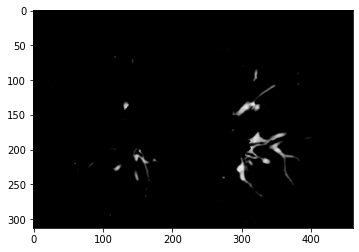

In [4]:
scan_path = "/mnt/data1/NLST/nrrd/T0/100004_img.nrrd"
mask_path = "/mnt/ibrahim/NLST/nrrd/lung_masks/T0/100004_img.nrrd"
scan = sitk_utils.load(scan_path)
mask = sitk_utils.load(mask_path)

# Originally, mask has a label for each lung, here we combine them into a single label
mask = sitk.Clamp(mask, upperBound=1)
# Erosion of the mask helps with getting rid of the 
mask = sitk.BinaryErode(mask)
# Mask out everything except lungs
scan = sitk_utils.apply_mask(scan, mask, masking_value=0, negated_mask=False, outside_value=hounsfield_units_range[0])

start, end = get_bounding_box_of_mask(mask)
scan = sitk_utils.slice_image(scan, start=start, end=end)

tensor = sitk_utils.get_tensor(scan)
tensor = torch.clamp(tensor, hounsfield_units_range[0], hounsfield_units_range[1])
tensor = normalization.min_max_normalize(tensor, hounsfield_units_range[0], hounsfield_units_range[1])
tensor = tensor.unsqueeze(0)
plt.imshow(tensor[0][50], cmap='gray')
print(tensor.shape)

In [5]:
tensor.min()

tensor(-1.)

torch.Size([1, 48, 256, 256])


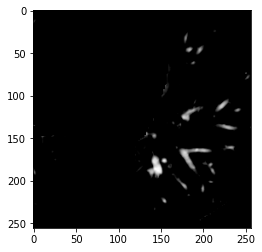

In [6]:
patch = monai.transforms.RandSpatialCrop((48,256,256), random_size=False)(tensor)
print(patch.shape)
plt.imshow(patch[0][24], cmap='gray')

In [7]:
tensor.shape

torch.Size([1, 96, 313, 460])

Skipping loading pretrained weights for non-default efficientnet-b0, pretrained=False, is_default_model=False


In [1]:
import pandas as pd
df = pd.read_csv("/mnt/data1/NLST/NLST_clinical_whole.csv")

/home/ibrahim/anaconda3/envs/aim_cds/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (47,264,284,285,286,287,288,853,854,961,978,985) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
df.packyear

0         42.5
1         47.0
2         40.0
3         34.0
4         50.0
         ...  
26717     46.0
26718    150.0
26719     92.0
26720     54.0
26721     73.5
Name: packyear, Length: 26722, dtype: float64